# 데이터 불러오고 훑어보기

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

In [14]:
X,y = mnist.data, mnist.target #추가로 DESCR 속성도 있음.

#둘 다 ndarray타입이다. 
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [15]:
#이미지 샘플은 70000개가 있고, 각 샘플은 784개의 특성을 가진다. 28*28사이즈의 이미지를 나타낸다. 각 픽셀(특성)은 그 픽셀의 밝기를 0~255의 값으로 나타낸다. 
print(X.shape)

(70000, 784)


이미지를 한 번 화면에 띄워보자.

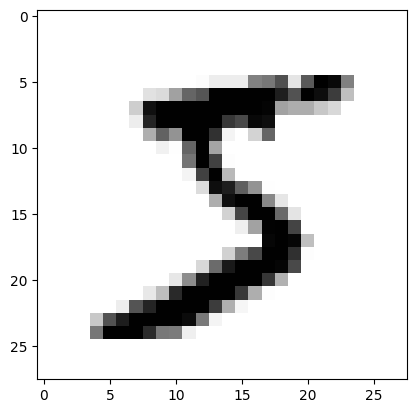

In [16]:
import matplotlib.pyplot as plt

def plot_digit(image):
    image_reshaped = image.reshape(28,28)
    plt.imshow(image_reshaped, cmap="binary")

plot_digit(X[0])

# 훈련, 테스트 데이터 분리

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 간단한 이진 분류기 훈련

우선 5임, 5아님을 나타내는 이진 타겟 벡터를 생성한다.

In [18]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [22]:
from sklearn.linear_model import SGDClassifier #확률적 경사 하강법을 사용하는 분류기, SGDClassifier는 매우 큰 데이터셋을 효율적으로 처리한다. 

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([X[0]])#이렇게 []로 감싸서 넣어줘야 한다. predict는 (n_samples, n_features) 형태의 2차원 배열을 요구합니다. 따라서, 단일 샘플을 예측할 때도 2차원 배열로 전달해야 합니다.

array([ True])

# 성능 측정

## 교차 검증을 사용한 정확도 측정

**k-폴드 교차검증**을 사용해서 모델의 **"정확도"**를 측정할 것이다. corss_val_score()함수를 사용해도 되는데, 나는 일단 한번 직접 구현해볼 것이다.

In [27]:
from sklearn.model_selection import StratifiedKFold #클래스별 비율이 유지되도록 계층적으로 샘플링 해준다.
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)#분할 횟수

#train_index는 훈련 데이터의 인덱스를 담은 배열, test_index는 테스트 데이터의 인덱스를 담은 배열이다.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    #훈련 폴드
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    #테스트 폴드
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    #모델 훈련
    clone_clf.fit(X_train_folds, y_train_folds)

    #테스트 폴드로 예측값 생성 및 정확도 계산
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)

    print(n_correct/len(y_pred))

0.9557
0.9648
0.9641


In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95505, 0.96555, 0.9614 ])

구현은 제대로 됐고, 정확도가 96%에 달한다. 모델이 되게 잘 만들어진 것인가 할 수 있지만, 함정이 있다.
지금 클래스 비율이 굉장히 불균형하기 때문에, 무지성으로 5아님으로 찍기만 해도 정확도가 90%에 달한다.

그래서 분류기의 성능을 평가할 때 정확도를 지표로 사용하는 것을 별로 좋아하지 않는다고 한다. 특히 불균형한 데이터셋을 다룰 때 그렇다.

## 오차행렬 (Confusion Matrix)

오차 행렬의 기본아이디어는 모든 A/B 쌍에 대해서 클래스 A의 샘플이 클래스 B로 분류된 횟루를 세는 것이다.
예를 들어서 숫자 8이미지가 2로 잘못 분류된 횟수를 보고 싶으면 행렬의 8행 2열을 보면 된다. 

오차행렬을 만드려면 먼저 입력에 대한 예측값부터 얻어야 한다.
이를 위해서 cross_val_predict()를 사용한다.
cross_val_score()와 똑같이 k-폴드 교차검증을 수행하는데, 얘처럼 정확도를 반환하지 않고, 각 테스트 폴드에서 얻은 예측 결과를 반환한다.
즉 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다.(훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 뜻)

In [29]:
from sklearn.model_selection import cross_val_predict

y_trained_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [30]:
print(y_trained_pred.shape)
print(y_trained_pred)

(60000,)
[ True False False ...  True False False]


In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_trained_pred)#레이블과 예측값을 입력으로 받는다.
cm

array([[53002,  1577],
       [  938,  4483]])

[53002,  1577]
[  938,  4483]

오차행렬의 결과는 이와 같다. 행은 실제 클래스, 열은 에측값이다. 인덱스 0번은 음성, 1번은 양성이다.
왼쪽 위는 진짜 음성(TN), 오른쪽 위는 가짜 양성(FP)
왼쪽 아래는 가짜 음성(FN), 오른쪽 아래는 진짜 양성(TP)

## 정밀도-재현율 트레이드 오프

오차행렬이 많은 정보를 제공해주지만 더 요약된 정보가 필요할 수도 있다.

이때 쓰는 것이 바로 **정밀도(Precision)**과 **재현율(Recall)**이다.

정밀도는 양성 예측의 정확도, 양성으로 판정된 것 중 진짜 양성의 비율 -> TP / TP + FP
재현율은 분류기가 정확하게 감지한 양성 샘플의 비율, 양성 샘플 중에서 양성으로 예측된 것의 비율 -> TP / TP + FN

In [46]:
#정밀도와 재현율 계산
from sklearn.metrics import precision_score, recall_score

print("precision", precision_score(y_train_5, y_trained_pred))#레이블, 예측값
print("recall", recall_score(y_train_5, y_trained_pred))#레이블, 예측값

precision 0.7397689768976897
recall 0.8269691938756687


그리고 정밀도와 재현율을 **F1**점수라고 하는 하나의 점수로 만들면 더 편할 수도 있다.
F1점수는 정밀도와 재현율의 조화평균이다. 
정밀도와 재현율이 비슷한 경우 F1점수가 높다. 그런데 이게 항상 좋은 것은 아니다. **정밀도-재현율 트레이드 오프**를 고려해야 한다.

SGDClassifier가 분류를 어떻게 하는지 보면서 정밀도-재현율 트레이드 오프를 이해해보자.
이 분류기는 **결정함수(Decision Function)**을 이용해서 각 샘플의 점수를 계산하고,
이 점수가 **임계값**보다 크면 양성, 작으면 음성으로 분류한다.

**결정 임게값**이 중요한다. 
임계값이 높아지면 정밀도가 높아지고 재현율이 낮아진다.
반대로 임계값이 낮아지면 정밀도가 낮아지고 재현율이 높아진다.

사이킷런에서 임계값을 내가 마음대로 설정할 수는 없지만
`decision_function()`을 사용하면 결정 점수를 얻을 수 있다. 이걸 이용해서 내가 마음대로 임계값을 걸면 된다.

In [33]:
print(sgd_clf.decision_function([X_train[0]]))

[4773.12329702]


**그래서 적절한 임계값을 어떻게 정할 수 있을까?** 
cross_cal_predict()함수를 사용해서 모든 샘플의 점수를 구해야 한다. 이번에는 예측값이 아니라 **결정 점수**를 얻는다.

In [34]:
#method="decision_function" 로 설정하면 결정 점수를 얻을 수 있다.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

y_scores에 담긴 결정 점수로 `precision_recall_curve`함수를 사용해서 가능한 **모든 임계값에 대해 정밀도와 재현율**을 계산할 수 있다.
계산결과로 임계값의 함수로 정밀도와 재현율을 그릴 수 있다.

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

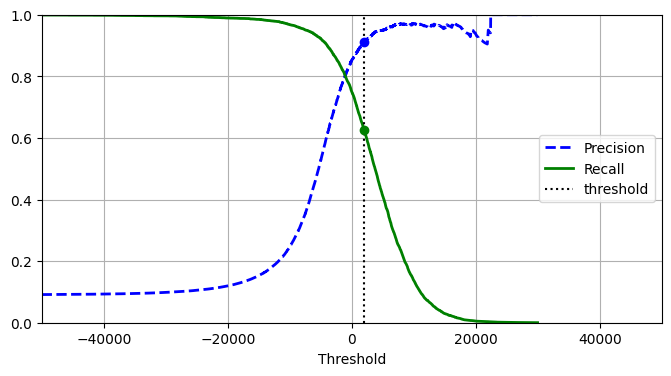

In [39]:
#임계값이 2000일 때의 정밀도와 재현유을 보여준다.
threshold = 2000

plt.figure(figsize=(8, 4))  # 추가 코드
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# 추가 코드 – 그림 3–5를 그리고 저장합니다
idx = (thresholds >= threshold).argmax()  # 첫 번째 index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

또 다른 방법은 정밀도에 대한 재현율 곡선을 그리는 것이다.

### PR곡선

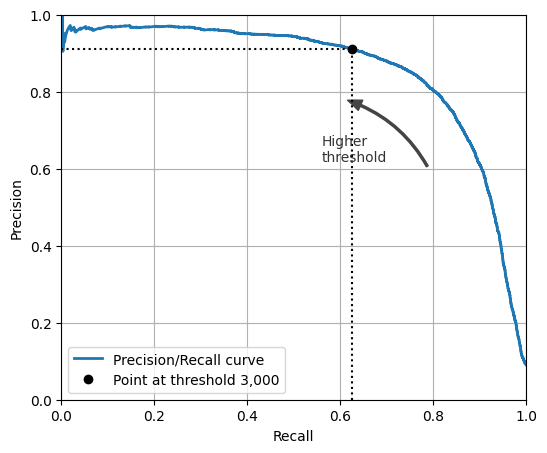

In [40]:
import matplotlib.patches as patches  # 추가 코드 – 구부러진 화살표를 그리기 위해서

plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

재현율 80% 근처에서 정밀도가 급속도로 나빠지는데, 이 하강점 직전을 정밀도-재현율 트레이드오프로 선택하는 것이 좋다고 한다. 물론 프로젝트에 따라 다름.

만약 정밀도 90%를 달성하는 것이 목적이라고 하자. 위의 그래프를 더듬으면서 정밀도가 90%일 때의 임계값을 찾을 수도 있지만, 이것보다 더 정확한 방법이 있다.

In [41]:
#idx_for_90_precisions는 정밀도가 90%인 지점의 precisions의 인덱스를 가지고 있다. 
idx_for_90_precisions = (precisions >= 0.9).argmax()#argmax는 최대값의 첫번째 인덱스를 반환한다. 여기에서는 첫번째 True가 반환되는 지점의 인덱스

#thresholds_for_90_precisions은 정밀도가 90%이기 위한 임계값을 가지고 있다. 
thresholds_for_90_precisions = thresholds[idx_for_90_precisions]
print(thresholds_for_90_precisions)

1565.1203506705338


In [45]:
#위에서 얻은 임게값을 바탕으로 계산해서 정말 저 임계값이면 90%의 정밀도에 도달할 수 있는지 확인해보자. 90%정밀도에 도달했다!!!
print("precision: ", precision_score(y_train_5, (y_scores > thresholds_for_90_precisions))) #(y_scores > thresholds_for_90_precisions))는 예측을 나타낸다. y_scores는 모든 샘플의 결정점수를 담음. 
print("recall: ", recall_score(y_train_5, (y_scores > thresholds_for_90_precisions)))

precision:  0.9000254388196388
recall:  0.6526471130787678


정밀도는 90%이지만 재현유리 65%수준이라서 별로 훌륭하지 않음. 

## ROC 곡선

ROC곡선도 이진 분류에서 널리 사용되는 도구라고 한다.
PR곡선과 매우 비슷하지만, 정밀도에 대한 재현율 곡선이 아니라

**거짓양성비율(FPR)에 대한 진짜양성비율(TPR)에 대한 곡선**이다. TPR은 재현율을 말하는 것이다. 

FPR은 1에서 진짜음성비율(TNR)을 뺀 값이다. 어찌보면 재현율의 음성버전? 같은 느낌이다.

정리하자면 ROC <- FPR에 대한 TPR의 곡선 == 1-TNR에 대한 TPR의 곡선

TNR = TN / TN + FP
TPR = TP / TP + FN

`roc_curve`함수를 사용해서 가능한 임계값에 대한 FPR과 TPR을 계산할 수 있다.

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

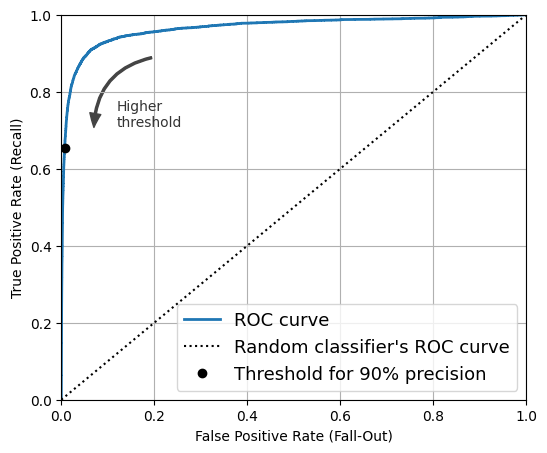

In [48]:
#idx_for_threshold_at_90는 정밀도가 90%일 떄의 임계값 인덱스
idx_for_threshold_at_90 = (thresholds <= thresholds_for_90_precisions).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
#tpr_90, fpr_90는 정밀도가 90%일 때의 tpr, fpr 값

plt.figure(figsize=(6, 5))  # 추가 코드
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# 추가 코드 – 그림 3–7을 그리고 저장합니다
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

여기에도 트레이드 오프가 있다. 
TPR(재현율)이 높을수록 FPR도 높아진다. 재현율이 높아지면 거짓양성이 많아진다는 당연한 얘기다. 

## AUC로 분류기의 성능 비교